# Example Notebook

This notebook implements many of the examples presented in the paper.


In [1]:
import grama as gr
DF = gr.Intention()
gr.hide_traceback() # To simplify errors shown in Jupyter
%matplotlib inline

# Core Functionality


In [2]:
md_example = (
    gr.Model("An example model")
    # Overloaded `>>` provides pipe syntax
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(f=df.x+df.y+df.z),
        var=["x", "y", "z"],
        out=["f"],
    )
    >> gr.cp_bounds(x=(-1, +1))
    >> gr.cp_marginals(
        y=gr.marg_mom("norm", mean=0, sd=1),
        z=gr.marg_mom("uniform", mean=0, sd=1),
    )
    >> gr.cp_copula_gaussian(
        df_corr=gr.df_make(var1="y", var2="z", corr=0.5)
    )
)

The model representation presents a helpful summary:


In [3]:
md_example

/Users/zach/Git/py_grama/grama/marginals.py:336: RuntimeWarning: divide by zero encountered in double_scalars


model: An example model

  inputs:
    var_det:
      x: [-1, 1]

    var_rand:
      y: (+0) norm, {'mean': '0.000e+00', 's.d.': '1.000e+00', 'COV': inf, 'skew.': 0.0, 'kurt.': 3.0}
      z: (+0) uniform, {'mean': '0.000e+00', 's.d.': '1.000e+00', 'COV': inf, 'skew.': 0.0, 'kurt.': 1.8}

    copula:
      Gaussian copula with correlations:
  var1 var2  corr
0    y    z   0.5

  functions:
      f0: ['x', 'y', 'z'] -> ['f']

Layered defaults

Calling plot_sinew_outputs....


/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


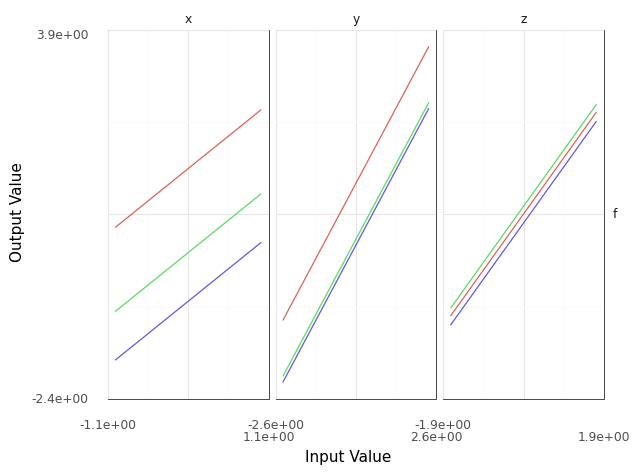

<ggplot: (8769032372953)>

In [4]:
(
    md_example
    >> gr.ev_sinews(df_det="swp")
    >> gr.pt_auto()
)

## Layered Defaults


In [5]:
p = (
    md_example
    >> gr.ev_sinews(df_det="swp") # Default parameters
    >> gr.pt_auto()               # Default visual
)
p.save("example-sweep.png")

Calling plot_sinew_outputs....


/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: example-sweep.png
/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Calling plot_sinew_outputs....


/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


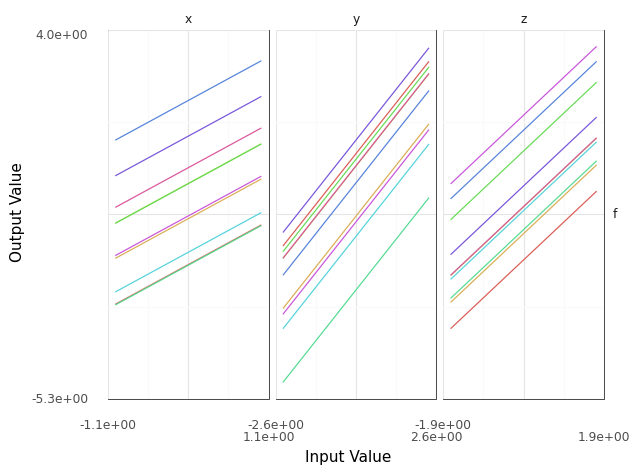

<ggplot: (8769032459554)>

In [6]:
(
    md_example
    ## Override default parameters
    >> gr.ev_sinews(df_det="swp", n_sweeps=10)
    >> gr.pt_auto()
)

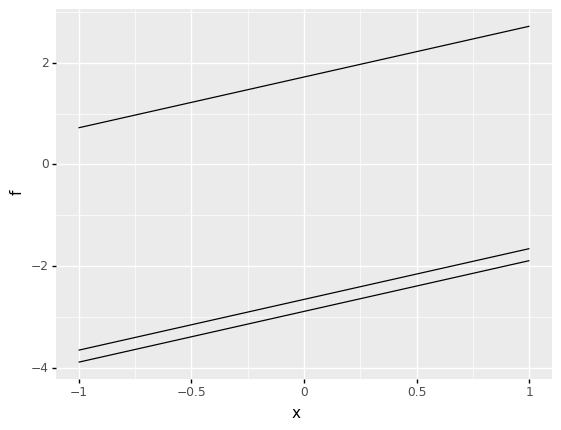

<ggplot: (8769053737491)>

In [7]:
(
    md_example
    >> gr.ev_sinews(df_det="swp")
    ## Construct a manual plot
    >> gr.tf_filter(DF.sweep_var == "x")
    >> gr.ggplot(gr.aes("x", "f", group="sweep_ind"))
    + gr.geom_line()
)

# Case Studies


## 1. Planned Errors as Teachable Moments

It is possible to define a grama model without a copula:


In [8]:
md_flawed = (
    gr.Model("An example model")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(f=df.x+df.y+df.z),
        var=["x", "y", "z"],
        out=["f"],
    )
    >> gr.cp_bounds(x=(-1, +1))
    >> gr.cp_marginals(
        y=gr.marg_mom("norm", mean=0, sd=1),
        z=gr.marg_mom("uniform", mean=0, sd=1),
    )
)


However, this flawed model will throw an error when used in a probabilistic analysis:


In [9]:
(
    md_flawed
    >> gr.ev_sample(n=1000, df_det="nom")
)

ValueError: 
Present model copula must be defined for sampling.
Use CopulaIndependence only when inputs can be guaranteed
independent. See the Documentation chapter on Random
Variable Modeling for more information.
https://py-grama.readthedocs.io/en/latest/source/rv_modeling.html

## 2. Encouraging Sound Analysis
